# **Stroke Prediction Model**

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

data = pd.read_csv('./train_strokes.csv')
df = data.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [3]:
# uniform format
df.columns = df.columns.str.lower()

# check for duplicate data based on ['id']
df.duplicated('id').sum()

0

In [4]:
# feature ['id'] is not needed for analysis
df.drop(['id'], axis=1, inplace=True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [6]:
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = df.columns.drop(numeric_cols)

# check unique values of categorical variables
for col in df[categorical_cols]:
    print(f'{col} : {df[col].unique()}')

gender : ['Male' 'Female' 'Other']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
smoking_status : [nan 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [7]:
# check ratio of target feature ['stroke']
print(df.stroke.value_counts(), df.stroke.value_counts(normalize=True)*100, sep='\n\n')

# imbalanced target class

stroke
0    42617
1      783
Name: count, dtype: int64

stroke
0    98.195853
1     1.804147
Name: proportion, dtype: float64


## Data Visualization

### Stroke by Age, Average Glucose Level, and BMI

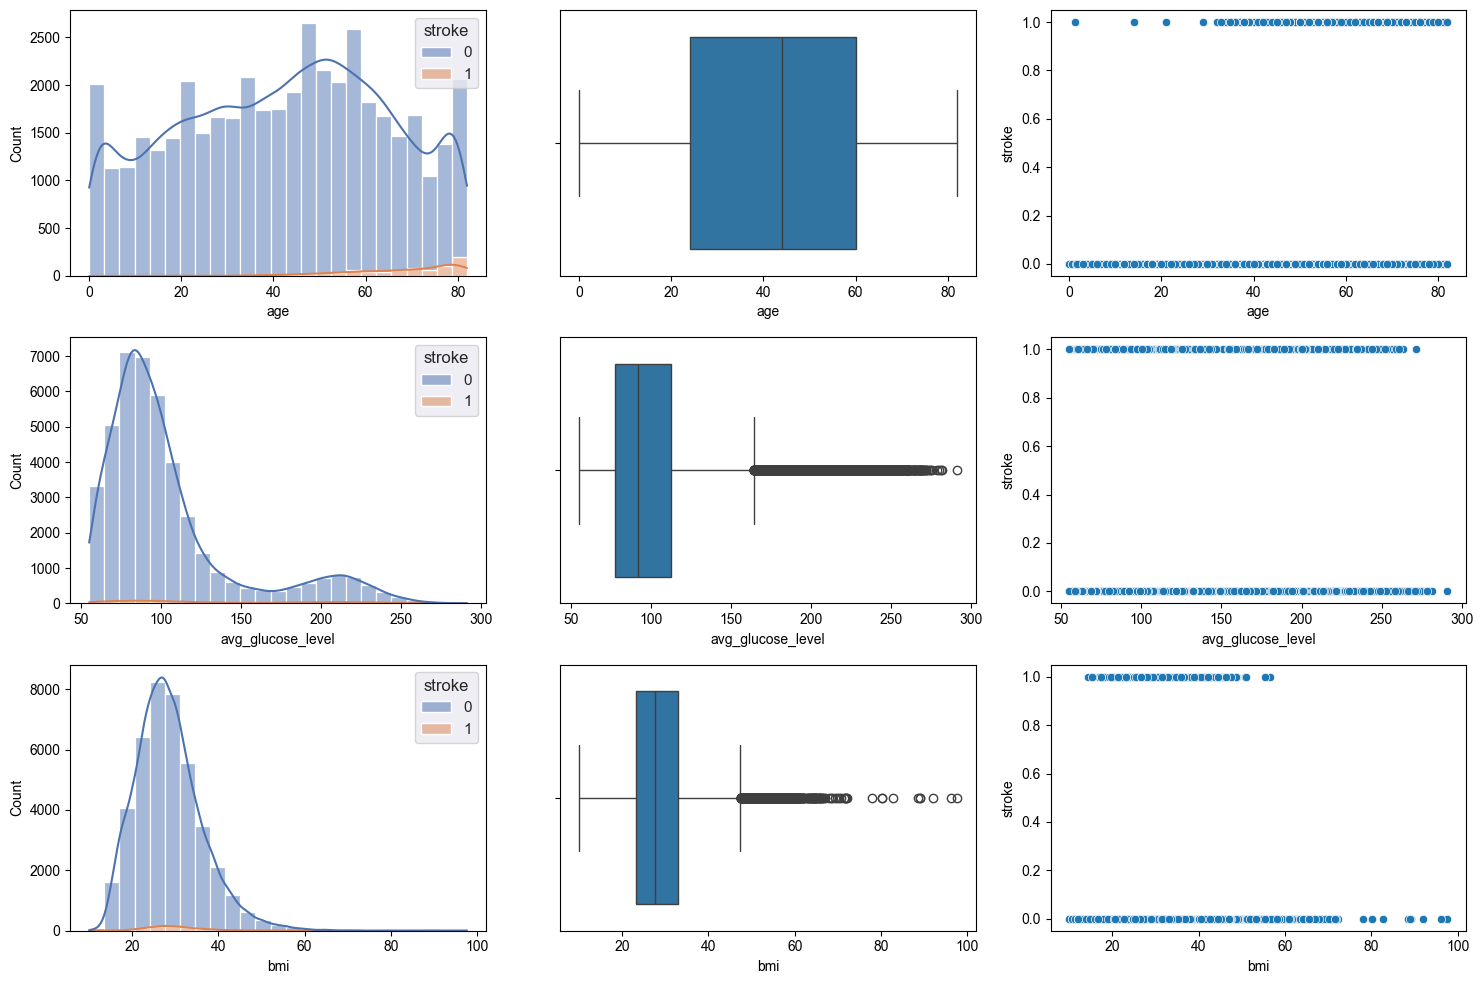

In [8]:
# numeric_cols = ['age', 'avg_glucose_level', 'bmi']
# categorical_cols = 'gender', 'hypertension', 'heart_disease', 'ever_married',
#                    'work_type','residence_type', 'smoking_status', 'stroke']

fig, axs = plt.subplots(3, 3, figsize=(15,10))
sns.set_theme()

for i, col in enumerate(numeric_cols):
    sns.histplot(df, x=col, hue='stroke', kde=True, bins=25, multiple='stack', ax=axs[i, 0])
    sns.boxplot(df, x=col, ax=axs[i, 1], )
    sns.scatterplot(df, x=col, y='stroke', ax=axs[i,2])

plt.tight_layout()

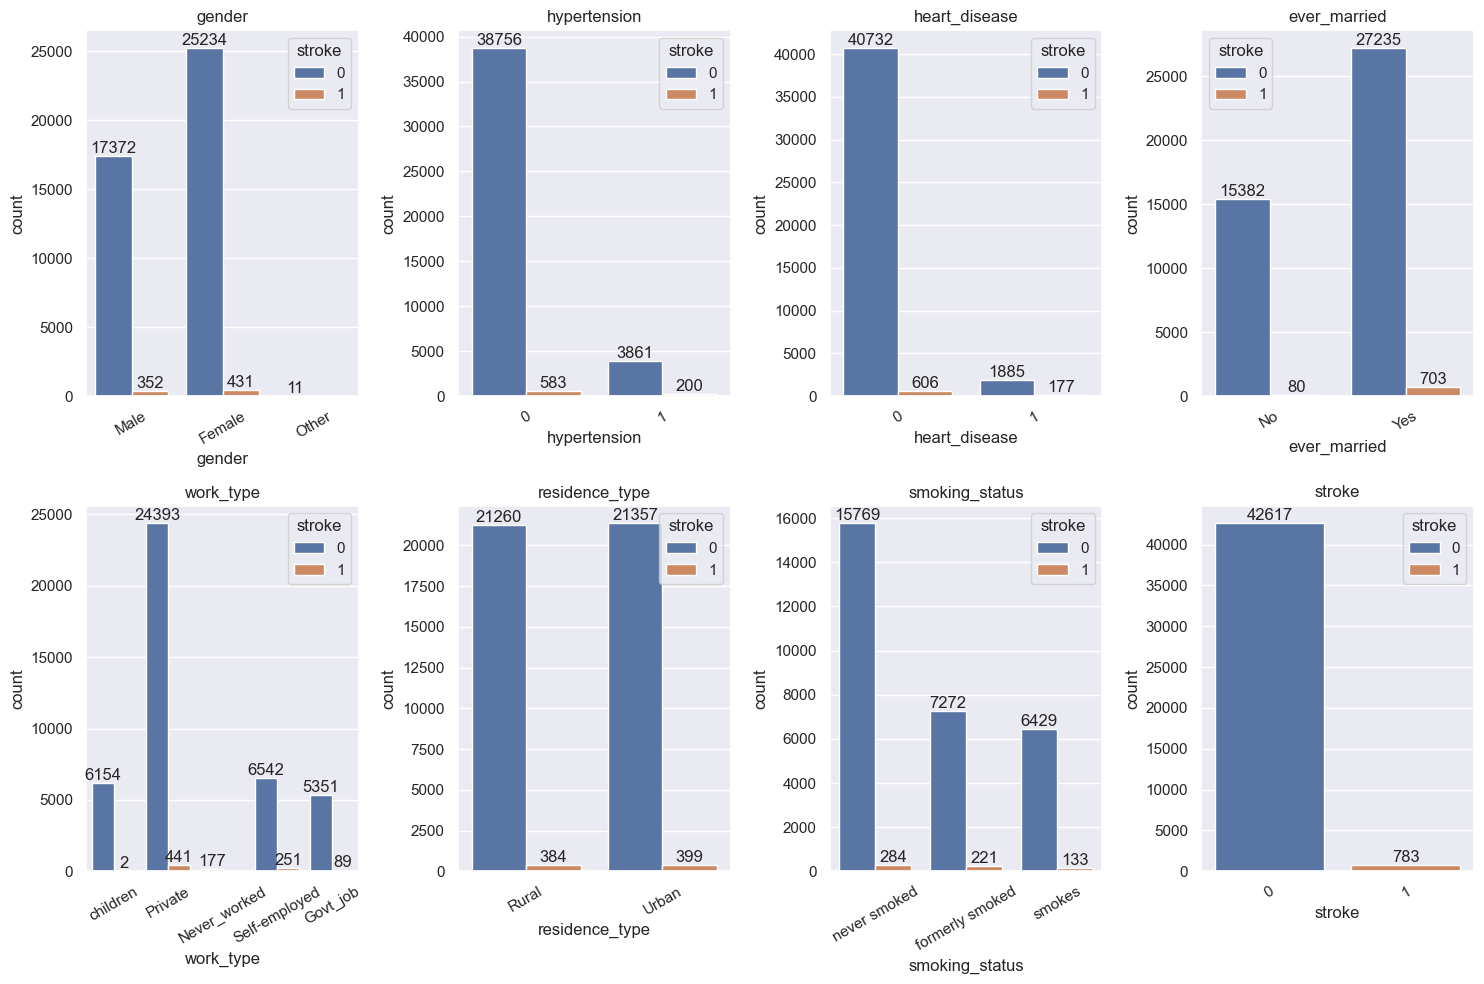

In [9]:
# numeric_cols = ['age', 'avg_glucose_level', 'bmi']
# categorical_cols = df.columns.drop(numeric_cols)

fig, axs = plt.subplots(len(categorical_cols)//4, 4, figsize=(15, 10))

for i, col in enumerate(categorical_cols):
        ax = sns.countplot(df, x=col, hue='stroke', ax=axs[i // 4, i % 4])
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=30)

        for container in ax.containers:
            ax.bar_label(container)

plt.tight_layout()

## Modeling

### Data Preprocessing

In [10]:
#check for missing values
df.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [11]:
# check values in ['gender']
print(df['gender'].value_counts())

# drop 'Other' due to insufficient data
df = df[df['gender']!='Other']
df['gender'].value_counts()

gender
Female    25665
Male      17724
Other        11
Name: count, dtype: int64


gender
Female    25665
Male      17724
Name: count, dtype: int64

count    41931.000000
mean        28.605156
std          7.770186
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: bmi, dtype: float64

median: 27.7


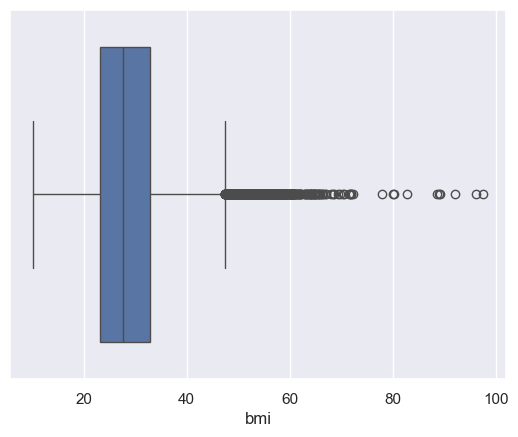

In [12]:
# visualization of ['bmi']
sns.boxplot(x=df['bmi'])
print(df['bmi'].describe())

# considering outliers, replace missing values with median
median = df['bmi'].median()
print(f'\nmedian: {median}')

In [13]:
# replace missing data in ['bmi'] with median
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# reassign missing values of ['smoking_status'] as 'unknown' instead of dropping them
df['smoking_status'].fillna('unknown', inplace=True)

# check missing data
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [14]:
# categorize feature ['avg_glucose_level'] based on Fasting Blood Sugar Test criteria by CDC
df['avg_glucose_level'] = pd.cut(x=df['avg_glucose_level'], 
                                bins=[0, 100, 126, np.inf], 
                                labels=['normal', 'prediabetic', 'diabetic'])

# categorize feature ['bmi'] based on standard by CDC
df['bmi'] = pd.cut(x=df['bmi'],
                    bins=[0, 18.5, 25, 30, np.inf],
                    labels=['underweight', 'normal', 'overweight', 'obese'])

# check unique values of categorical variables
for col in df.drop(['age'], axis=1):
    print(f'{col} : {df[col].unique()}')

gender : ['Male' 'Female']
hypertension : [0 1]
heart_disease : [0 1]
ever_married : ['No' 'Yes']
work_type : ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
residence_type : ['Rural' 'Urban']
avg_glucose_level : ['normal', 'prediabetic', 'diabetic']
Categories (3, object): ['normal' < 'prediabetic' < 'diabetic']
bmi : ['underweight', 'obese', 'normal', 'overweight']
Categories (4, object): ['underweight' < 'normal' < 'overweight' < 'obese']
smoking_status : ['unknown' 'never smoked' 'formerly smoked' 'smokes']
stroke : [0 1]


In [15]:
df.dtypes

gender                 object
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
work_type              object
residence_type         object
avg_glucose_level    category
bmi                  category
smoking_status         object
stroke                  int64
dtype: object

In [16]:
# change data into adequate data types
def convert_dtypes(df):
    for col in df.drop('age', axis=1):
        df[col] = df[col].astype('category')
    df['age'] = df['age'].astype('int')

convert_dtypes(df)

df.dtypes

gender               category
age                     int64
hypertension         category
heart_disease        category
ever_married         category
work_type            category
residence_type       category
avg_glucose_level    category
bmi                  category
smoking_status       category
stroke               category
dtype: object

### Modeling

In [17]:
# differentiate feature variables & target variable
X = df.drop('stroke', axis=1)
y = df['stroke']


"""It is important to split data before resampling to retain original data distribution.
Resampling to adjust data imbalance is only applied to the train data to improve the accuracy of ML models, not the test data."""
# split train & test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)

print(f"Train dataset-{y_train.value_counts(normalize=True)*100} \n\nTest dataset-{y_val.value_counts(normalize=True)*100}")

Train dataset-stroke
0    98.196122
1     1.803878
Name: proportion, dtype: float64 

Test dataset-stroke
0    98.193215
1     1.806785
Name: proportion, dtype: float64


In [18]:
X_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')

In [35]:
# scale & encode data
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ['age']),
        ("cat", OrdinalEncoder(), X_train.columns.drop('age'))
    ]
)

pd.DataFrame(transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())

,num__age,cat__gender,cat__hypertension,cat__heart_disease,cat__ever_married,cat__work_type,cat__residence_type,cat__avg_glucose_level,cat__bmi,cat__smoking_status
0,0.342915,1.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,2.0
1,0.254200,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0
2,0.475988,1.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,2.0
3,-0.499878,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0
4,0.963921,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
32536,1.762356,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,3.0
32537,-0.100660,1.0,0.0,0.0,1.0,3.0,0.0,1.0,2.0,1.0
32538,-0.455520,1.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,1.0
32539,-1.209598,0.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,3.0


In [37]:
X_train.shape

(32541, 10)

* SVM
* Decision tree
* Random Forest
* Gradient Boosting
* KNN
* XGBclassifier
